<a href="https://colab.research.google.com/github/JungOhLee/LiTS_example/blob/main/PredictWithModel3DCrop160.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Paths and Files

In [1]:
from google.colab import drive 
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.6 MB/s eta 0:00:00


In [3]:
!git clone https://github.com/JungOhLee/LiTS_example.git ./git_clone
!mv  -v ./git_clone/* .

Cloning into './git_clone'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 149 (delta 36), reused 8 (delta 1), pack-reused 68
Receiving objects: 100% (149/149), 52.72 MiB | 10.28 MiB/s, done.
Resolving deltas: 100% (56/56), done.
renamed './git_clone/augmentation.py' -> './augmentation.py'
renamed './git_clone/BoneMeta_3D_v1.1_All128_DropRes.ipynb' -> './BoneMeta_3D_v1.1_All128_DropRes.ipynb'
renamed './git_clone/CropAllLiver.ipynb' -> './CropAllLiver.ipynb'
renamed './git_clone/LiverTumorSeg_CropAll160_DropRes.ipynb' -> './LiverTumorSeg_CropAll160_DropRes.ipynb'
renamed './git_clone/NpyToNifti.ipynb' -> './NpyToNifti.ipynb'
renamed './git_clone/PredictWithModel3DAllCaseAll128.ipynb' -> './PredictWithModel3DAllCaseAll128.ipynb'
renamed './git_clone/PredictWithModel3DCrop160.ipynb' -> './PredictWithModel3DCrop160.ipynb'
renamed './git_clone/PrepareDataset.ipynb' -> './PrepareDataset.i

In [4]:
import os
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import SimpleITK as sitk
import random
import multiprocessing 
import time
from multiprocessing import Pool
multiprocessing.cpu_count()

import torch 
import time
import os, glob
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
from skimage import color

In [5]:
MODEL_TO_LOAD = 'liver_tumor_crop_3D_Unet_DropRes_lv5_crop160_model_epoch200'
PATCH_SIZE = (96,160,160)

# BATCH_SIZE = 120
BATCH_SIZE = 1
NUM_WORKERS = 2

BASE_DIR = '/gdrive/MyDrive/LiTS_sample'
IMG_FOLDER_NAME = 'image_crop_160'
LABEL_FOLDER_NAME = 'mask_crop_160'
PRED_FOLDER_NAME = 'preds_crop_160'

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [6]:
PRED_DIR = os.path.join(BASE_DIR, PRED_FOLDER_NAME)
os.makedirs(PRED_DIR, exist_ok=True)
SAVING_DIR = os.path.join(PRED_DIR, MODEL_TO_LOAD)
os.makedirs(SAVING_DIR, exist_ok=True)
SAVING_DIR_NPY = os.path.join(SAVING_DIR, "numpy")
os.makedirs(SAVING_DIR_NPY, exist_ok=True)

In [7]:
IMG_DIR = os.path.join(BASE_DIR, IMG_FOLDER_NAME)
LABEL_DIR = os.path.join(BASE_DIR, LABEL_FOLDER_NAME)

IMG_FILES = os.listdir(IMG_DIR)
LABEL_FILES = os.listdir(LABEL_DIR)

def get_img_path(file): 
    return os.path.join(IMG_DIR, file)

def get_label_path(file):
    return os.path.join(LABEL_DIR, file)

def case_to_file(case):
    return case+'.npy'

def file_to_case(file_name):
    return file_name.split('.')[0]

set(IMG_FILES).issubset(LABEL_FILES)

True

In [8]:
print(IMG_DIR, len(IMG_FILES))
print(LABEL_DIR, len(LABEL_FILES))

/gdrive/MyDrive/LiTS_sample/image_crop_160 51
/gdrive/MyDrive/LiTS_sample/mask_crop_160 51


In [9]:
TRAIN_FILES = [f"volume-{i}.npy" for i in range(45)]
VAL_FILES = [f"volume-{i}.npy" for i in range(45,51)]
TEST_FILES = [f"volume-{i}.npy" for i in range(45,51)]

In [10]:
TRAIN_FILES = list(set(TRAIN_FILES) - set(VAL_FILES) - set(TEST_FILES))
VAL_FILES = list(set(VAL_FILES))
TEST_FILES = list(set(TEST_FILES))

print(f'''
train: {len(TRAIN_FILES)}
val: {len(VAL_FILES)}
test: {len(TEST_FILES)}
total: {len(TRAIN_FILES + VAL_FILES + TEST_FILES)}
''')


train: 45
val: 6
test: 6
total: 57



# Load Model

In [11]:
import logging
log = logging.getLogger("3DUnet")
# log.setLevel(logging.WARN)
log.setLevel(logging.INFO)
# log.setLevel(logging.DEBUG)

In [14]:
from torch.optim import SGD, AdamW, RMSprop
from torch import nn
from pytorch3dunet.unet3d.model import UNet3D, ResidualUNet3D, DropResidualUNet3D

def initModel():    
    segmentation_model = DropResidualUNet3D(in_channels=3, out_channels=1, num_groups=24, f_maps=24, final_sigmoid=True, testing=True, num_levels=5)
#     segmentation_model = ResidualUNet3D(in_channels=3, out_channels=1, num_groups=32, f_maps=32, final_sigmoid=True, testing=True, num_levels=5)
    # augmentation_model = SegmentationAugmentation(**self.augmentation_dict)

    if USE_CUDA:
        log.info("Using CUDA; {} devices.".format(torch.cuda.device_count()))
        if torch.cuda.device_count() > 1:
            segmentation_model = nn.DataParallel(segmentation_model)
            # augmentation_model = nn.DataParallel(augmentation_model)
        segmentation_model = segmentation_model.to(DEVICE)
        # augmentation_model = augmentation_model.to(DEVICE)

    return segmentation_model #, augmentation_model

def initOptimizer():
    return AdamW(segmentation_model.parameters(), lr=0.00005, weight_decay=0.00001)
    # return SGD(segmentation_model.parameters(), lr=0.001, momentum=0.99)

segmentation_model = initModel()
optimizer = initOptimizer()

# Load model
if MODEL_TO_LOAD :
  model_folder = os.path.join(BASE_DIR, 'models_crop')
  model_path = os.path.join(model_folder, MODEL_TO_LOAD)
  seg_dict = torch.load(model_path, map_location='cpu')
  if torch.cuda.device_count() > 1:
    segmentation_model.module.load_state_dict(seg_dict['model_state'])
  else:
    segmentation_model.load_state_dict(seg_dict['model_state'])

INFO:3DUnet:Using CUDA; 1 devices.


# Preprocess Images

In [ ]:
import torch.nn.functional as F

# Pytorch 3D image tensor = Depth, Height, Weight
#w(l-> r), h(t->b), d(u->d) 순서로군

In [21]:
def pad_for_division(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    assert patch_d % 32 == 0 & patch_h % 32 == 0 & patch_w % 32 == 0, "Patch size should be divided by 32"
    padding_d = patch_d - image.size(0)%patch_d
    padding_h = patch_h - image.size(1)%patch_h
    padding_w = patch_w - image.size(2)%patch_w
    padded_image = F.pad(image, (0, padding_w, 0, padding_h, 0, padding_d))
    return padded_image 

def pad_for_half(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    padded_image = F.pad(image, (patch_w//2, patch_w//2, patch_h//2, patch_h//2, patch_d//2, patch_d//2))
    return padded_image 

    
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

def convert_to_multi_channel_img(image, windows):
    adjusted_images = [adjust_window(image, window) for window in windows]
    return torch.stack(adjusted_images)

# Process : padding -> adjust windows -> unfold -> neural network -> fold -> crop
#           another padding -> adjust windows -> unfold -> neural network -> fold -> crop 
#           average all by 2 -> compare with the label. 
# 원래는 8개로 해야되는데, 간이 버전이라고 생각해볼 수 있겠음. 

def pred_image_with_model(padded_image, model, batch_size, patch_size):
    '''
    padded_image : image tensor with size of [D, H, W]
    patch_size : tuple with size of 3
    return pred_label : tensor with size of [D, H, W]
    '''
    windows = [(500,200), (700,400),(400,80)]
    input_channel = padded_image.size(0)
    output_channel = 1
    patch_d, patch_h, patch_w = patch_size 
    total_batch_size = batch_size * torch.cuda.device_count()

    patches = padded_image.unfold(0, patch_d, patch_d).unfold(1, patch_h, patch_h).unfold(2, patch_w, patch_w)
    unfold_shape = patches.size()
    patches = patches.reshape(-1, patch_d, patch_h, patch_w)
    
    processed_patches = torch.zeros_like(patches)
    iter_num = int(np.ceil(patches.size(0)/total_batch_size))
    for i in range(iter_num):
        start = i * total_batch_size
        end = (i+1) * total_batch_size
        batch = patches[start:end]
        batch = convert_to_multi_channel_img(batch, windows)
        batch = batch.permute(1,0,2,3,4)
        proccessed_batch = model(batch).squeeze(1)
        processed_patches[start:end] = proccessed_batch
    
    pred_patches = processed_patches.view(unfold_shape)
    output_d = unfold_shape[0] * unfold_shape[3]
    output_h = unfold_shape[1] * unfold_shape[4]
    output_w = unfold_shape[2] * unfold_shape[5]
    pred_patches = pred_patches.permute(0, 3, 1, 4, 2, 5)
    pred_label = pred_patches.reshape(output_d, output_h, output_w)
    return pred_label

In [16]:
def predict_one_case(image_t, batch_size ,patch_size):
    with torch.no_grad():
        segmentation_model.eval()
        pred_label = pred_image_with_model(image_t, segmentation_model, batch_size, patch_size)

    return pred_label

In [17]:
def getDice(prediction_g, label_g, epsilon=1):
    diceLabel_g = label_g.sum(dim=[0,1,2])
    dicePrediction_g = prediction_g.sum(dim=[0,1,2])
    diceCorrect_g = (prediction_g * label_g).sum(dim=[0,1,2])

    diceRatio_g = (2 * diceCorrect_g + epsilon) \
        / (dicePrediction_g + diceLabel_g + epsilon)

    return diceRatio_g

In [18]:
def savePred(pred_t, filename):
    file_path = os.path.join(SAVING_DIR_NPY, filename)
    np.save(file_path, pred_t.cpu().numpy().astype(np.uint8))
    
def saveLog(log_string):
    with open(f'{SAVING_DIR}/log.txt', 'w') as f:
        f.write(log_string)

In [22]:
from monai.losses import DiceLoss
def doPrediction(files, patch_size):
    dice_metric = np.zeros(len(files))
    log_text =''
    for i, file in enumerate(files):
        image = np.load(get_img_path(file))
        image_t = torch.tensor(image)

        label = np.load(get_label_path(file))
        
        label_t = torch.tensor(label)
        
        windows = [(500,200), (700,400),(400,80)]
        with torch.no_grad():
            segmentation_model.eval()
            pred_label_one_hot = segmentation_model(convert_to_multi_channel_img(image_t, windows)[np.newaxis,:].cuda())

        pred_mc = torch.argmax(pred_label_one_hot, dim=1)[0]

        dice = diceLoss(pred_mc[np.newaxis,:], label_t[np.newaxis,:].cuda())
        # dice_sig = getDice(pred, label_t, epsilon=0.01)
        
        dice_metric[i] = dice
        
        log = f"""
Case: {file_to_case(file)}
    DICE = {dice}
    """
        print(log)
        log_text = log_text + log
        savePred(pred_mc, file)

    log_text = log_text + log
    saveLog(log_text)
    print(log)
    return dice_metric

diceLoss = DiceLoss(to_onehot_y=False, include_background=False)

In [23]:
t = time.perf_counter()
dice = doPrediction(IMG_FILES, PATCH_SIZE)

elapsed_time = time.perf_counter() - t
print(f'Time consumed: {elapsed_time}s')


Case: volume-0
    DICE = 0.5052630305290222
    

Case: volume-1
    DICE = 0.5894736051559448
    

Case: volume-7
    DICE = 0.505263090133667
    

Case: volume-2
    DICE = 0.19999998807907104
    

Case: volume-8
    DICE = 0.45263150334358215
    

Case: volume-9
    DICE = 0.4736841022968292
    

Case: volume-3
    DICE = 0.09473682940006256
    

Case: volume-10
    DICE = 0.4631578028202057
    

Case: volume-4
    DICE = 0.936842143535614
    

Case: volume-11
    DICE = 0.30526310205459595
    

Case: volume-5
    DICE = 0.07368416339159012
    

Case: volume-6
    DICE = 0.5157893896102905
    

Case: volume-12
    DICE = 0.06315787881612778
    

Case: volume-13
    DICE = 0.46315792202949524
    

Case: volume-14
    DICE = 0.07368417084217072
    

Case: volume-21
    DICE = 0.38947364687919617
    

Case: volume-22
    DICE = 0.25263160467147827
    

Case: volume-15
    DICE = 0.07368414103984833
    

Case: volume-23
    DICE = 0.27368417382240295
    

Case: volum

In [24]:
%matplotlib inline

(array([12.,  6.,  9.,  5.,  6.,  6.,  3.,  0.,  3.,  1.]),
 array([0.        , 0.09368421, 0.18736843, 0.28105264, 0.37473686,
        0.46842107, 0.56210529, 0.6557895 , 0.74947371, 0.84315793,
        0.93684214]),
 <a list of 10 Patch objects>)

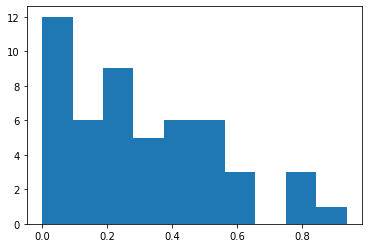

In [25]:
plt.hist(dice)

In [26]:
np.mean(dice)

0.31124868433849484

# Show an Example

In [27]:
import matplotlib.pyplot as plt

def slice_img(img, offset, end, interval):
  if end is None:
    end = len(img)
  else: 
    if end > len(img): 
      end = len(img)
    if end <= offset:
      end = offset + 1
  return img[offset:end:interval]

def show_numpy_img(np_img, offset=0, end=None, interval=5, title=''): 
  sliced_img = slice_img(np_img, offset, end, interval)

  figsize_per_img = 3
  num_col = 5
  num_row = int(np.ceil(sliced_img.shape[0] / num_col))
  # fig, axs = plt.subplots(num_row, num_col, figsize = (figsize_per_img*num_col, figsize_per_img*num_row))
  plt.figure(figsize=(figsize_per_img*num_col, figsize_per_img*num_row))
  for i, img in enumerate(sliced_img):
    if i >= num_col*num_row:
      continue
    # axs[i].imshow(img)
    plt.subplot(num_row, num_col, i+1)
    plt.imshow(img, 'gray')
    # plt.title()
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

#npy image 정보 보여주기 
def show_img_info(np_img):
  print('Shape:', np_img.shape)
  print('DType:', np_img.dtype)
  print('Max:', np_img.max())
  print('Min:', np_img.min())
  print(np_img)


#npy image, npy label 
#image, label 동시에 그려줌
def plot_img_and_label(np_img, label, interval = 5, offset = 0, end=None, figsize_per_image = 5):
  sliced_img = slice_img(np_img, offset, end, interval)
  sliced_label = slice_img(label, offset, end, interval)
  
  num_row = len(sliced_img)
  num_col = 2

  f = plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))

  for i in range(0, num_row):
    plt.subplot(num_row, num_col, i*num_col+1)
    tissue_image = sliced_img[i]
    plt.imshow(tissue_image, 'gray')

    plt.subplot(num_row, num_col, i*num_col+2)
    mask = sliced_label[i]
    # # Method with SimpleITK
    # label_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(0,255,0))
    # plt.imshow(sitk.GetArrayFromImage(label_on_tissue), 'gray')
    # Method with skimage
    label_on_tissue = color.label2rgb(mask,tissue_image, bg_label=0)
    plt.imshow(label_on_tissue)

  plt.tight_layout()
#   plt.show()
  return f

In [28]:
def plot_img_label_pred(image_npy, label_npy, pred_npy, interval = 5, offset = 0, end=None, figsize_per_image = 5, show_only_positive = False):
    sliced_img = slice_img(image_npy, offset, end, interval)
    sliced_label = slice_img(label_npy, offset, end, interval)
    sliced_pred = slice_img(pred_npy, offset, end, interval)

    if show_only_positive:
        positive_idx = (sliced_label + sliced_pred).sum(axis = (1,2)) > 0.5
        sliced_img = sliced_img[positive_idx]
        sliced_label = sliced_label[positive_idx]
        sliced_pred = sliced_pred[positive_idx]
    
    num_row = len(sliced_img)
    num_col = 3
    
    plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))

    for i in range(0, num_row):
        plt.subplot(num_row, num_col, i*num_col+1)
        tissue_image = sliced_img[i]
        plt.imshow(tissue_image, 'gray')

        plt.subplot(num_row, num_col, i*num_col+2)
        mask = sliced_label[i]
        label_on_tissue = color.label2rgb(mask,tissue_image, bg_label=0)
        # label_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(0,255,0))
        plt.imshow(label_on_tissue)
        
        plt.subplot(num_row, num_col, i*num_col+3)
        mask = sliced_pred[i]
        pred_on_tissue = color.label2rgb(mask,tissue_image, bg_label=0)
        # pred_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(255,0,0))
        plt.imshow(pred_on_tissue)

    plt.tight_layout()
    plt.show()

In [29]:
sample_file = VAL_FILES[0]

In [30]:
def convert_to_multi_channel_img(image, windows):
    adjusted_images = [adjust_window(image, window) for window in windows]
    return torch.stack(adjusted_images)

In [33]:
image = np.load(get_img_path(sample_file))
image_t = torch.tensor(image)

label = np.load(get_label_path(sample_file))

windows = [(500,200), (700,400),(400,80)]
with torch.no_grad():
    segmentation_model.eval()
    pred_label_one_hot = segmentation_model(convert_to_multi_channel_img(image_t, windows)[np.newaxis,:].cuda())

In [42]:
# pred_mc = torch.argmax(pred_label_one_hot, dim=1)[0]
pred_mc = pred_label_one_hot[0,0,:] > 0.2

In [43]:
%matplotlib inline

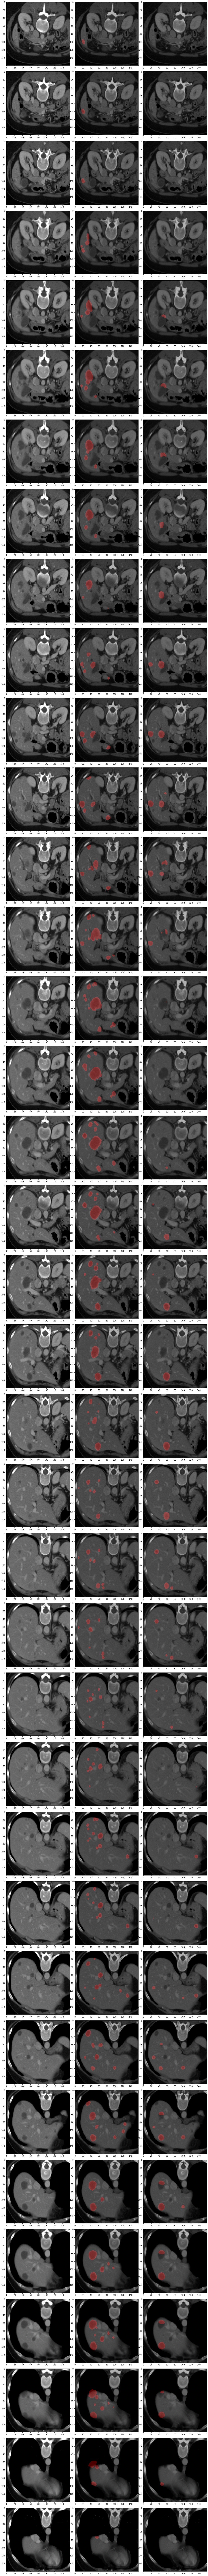

In [44]:
plot_img_label_pred((adjust_window(image,(700,200))*255).astype(np.uint8), label.astype(np.uint8), pred_mc.cpu().numpy().astype(np.uint8), show_only_positive = True, interval =2)